In [2]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tabulate import tabulate


In [3]:
num_samples = 1000
signal_length = 1024
fs = 1.0
X_t = np.sin(np.linspace(0, 2 * np.pi, signal_length))
epochs = 20
learning_rate = 0.001
test_size = 0.2
batch_size = 64
sigmas = np.logspace(-1, 1.5, 15)


In [4]:
# Diccionario para guardar resultados
results = {
    'Sigma': sigmas,
    'MLP MSE': [],
    'MLP RMSE': [],
    'MLP MAE': [],
    'MLP with Avg PSD MSE': [],
    'MLP with Avg PSD RMSE': [],
    'MLP with Avg PSD MAE': [],
    'LSTM MSE': [],
    'LSTM RMSE': [],
    'LSTM MAE': []
}



In [5]:
# Simulación y entrenamiento (similar a la sección anterior)
def calculate_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    return mse, rmse, mae

def train_mlp(X_train, y_train, X_test, y_test):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(X_train.shape[1])
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=(X_test, y_test), verbose=0)
    return model


def train_lstm(X_train, y_train, X_test, y_test):
    X_train_lstm = X_train[..., np.newaxis]
    X_test_lstm = X_test[..., np.newaxis]
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(32),
        Dense(X_train.shape[1])
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=(X_test_lstm, y_test), verbose=0)
    return model

for sigma in sigmas:
    noise_variance = sigma ** 2
    noise = np.random.randn(num_samples, signal_length) * np.sqrt(noise_variance)
    signals = X_t + noise

    psd_data = np.array([welch(signal, fs=fs, nperseg=256)[1] for signal in signals])
    avg_psd = np.mean(psd_data, axis=0)

    X_train, X_test, y_train, y_test = train_test_split(psd_data, psd_data, test_size=test_size, random_state=42)

    mlp_model = train_mlp(X_train, y_train, X_test, y_test)
    y_pred_mlp = mlp_model.predict(X_test)
    mse, rmse, mae = calculate_metrics(y_test, y_pred_mlp)
    results['MLP MSE'].append(mse)
    results['MLP RMSE'].append(rmse)
    results['MLP MAE'].append(mae)

    mlp_avg_model = train_mlp(X_train, np.tile(avg_psd, (X_train.shape[0], 1)),
                              X_test, np.tile(avg_psd, (X_test.shape[0], 1)))
    y_pred_mlp_avg = mlp_avg_model.predict(X_test)
    mse, rmse, mae = calculate_metrics(np.tile(avg_psd, (X_test.shape[0], 1)), y_pred_mlp_avg)
    results['MLP with Avg PSD MSE'].append(mse)
    results['MLP with Avg PSD RMSE'].append(rmse)
    results['MLP with Avg PSD MAE'].append(mae)

    lstm_model = train_lstm(X_train, y_train, X_test, y_test)
    y_pred_lstm = lstm_model.predict(X_test[..., np.newaxis])
    mse, rmse, mae = calculate_metrics(y_test, y_pred_lstm)
    results['LSTM MSE'].append(mse)
    results['LSTM RMSE'].append(rmse)
    results['LSTM MAE'].append(mae)


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


c:\Users\Usuario\Desktop\Developments\unal\2024-1S\Signals-Theory\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━

In [6]:
# Convertir resultados a DataFrame
df_results = pd.DataFrame(results)

# Crear DataFrames para cada modelo
df_mlp = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['MLP MSE'],
    'RMSE': df_results['MLP RMSE'],
    'MAE': df_results['MLP MAE']
})

df_mlp_avg = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['MLP with Avg PSD MSE'],
    'RMSE': df_results['MLP with Avg PSD RMSE'],
    'MAE': df_results['MLP with Avg PSD MAE']
})

df_lstm = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['LSTM MSE'],
    'RMSE': df_results['LSTM RMSE'],
    'MAE': df_results['LSTM MAE']
})

# Mostrar tablas con formato personalizado
def mostrar_tabla(df, titulo):
    print(f"\n{titulo}")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))

mostrar_tabla(df_mlp, "Tabla de métricas para MLP")
mostrar_tabla(df_mlp_avg, "Tabla de métricas para MLP con PSD promedio")
mostrar_tabla(df_lstm, "Tabla de métricas para LSTM")


Tabla de métricas para MLP
╒═══════════╤══════════════════╤══════════════╤══════════════╕
│     Sigma │              MSE │         RMSE │          MAE │
╞═══════════╪══════════════════╪══════════════╪══════════════╡
│  0.1      │      9.6919e-05  │   0.00984474 │   0.00718217 │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  0.150859 │      0.000471125 │   0.0217054  │   0.0161155  │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  0.227585 │      0.00205172  │   0.0452959  │   0.0337174  │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  0.343332 │      0.00958536  │   0.0979049  │   0.0753538  │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  0.517947 │      0.046616    │   0.215907   │   0.16797    │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  0.781371 │      0.224019    │   0.473307   │   0.370201   │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  1.17877  │      1.13532 

In [ ]:
import matplotlib.pyplot as plt

# Convertir resultados a DataFrame
df_results = pd.DataFrame(results)

# Crear DataFrames para cada modelo
df_mlp = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['MLP MSE'],
    'RMSE': df_results['MLP RMSE'],
    'MAE': df_results['MLP MAE']
})

df_mlp_avg = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['MLP with Avg PSD MSE'],
    'RMSE': df_results['MLP with Avg PSD RMSE'],
    'MAE': df_results['MLP with Avg PSD MAE']
})

df_lstm = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['LSTM MSE'],
    'RMSE': df_results['LSTM RMSE'],
    'MAE': df_results['LSTM MAE']
})

# Mostrar tablas con formato personalizado
def mostrar_tabla(df, titulo):
    print(f"\n{titulo}")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))
    df.plot(x='Sigma', logy=True, kind='bar')
    plt.show()

mostrar_tabla(df_mlp, "Tabla de métricas para MLP")
mostrar_tabla(df_mlp_avg, "Tabla de métricas para MLP con PSD promedio")
mostrar_tabla(df_lstm, "Tabla de métricas para LSTM")


Tabla de métricas para MLP
╒═══════════╤══════════════════╤══════════════╤══════════════╕
│     Sigma │              MSE │         RMSE │          MAE │
╞═══════════╪══════════════════╪══════════════╪══════════════╡
│  0.1      │      9.6919e-05  │   0.00984474 │   0.00718217 │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  0.150859 │      0.000471125 │   0.0217054  │   0.0161155  │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  0.227585 │      0.00205172  │   0.0452959  │   0.0337174  │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  0.343332 │      0.00958536  │   0.0979049  │   0.0753538  │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  0.517947 │      0.046616    │   0.215907   │   0.16797    │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  0.781371 │      0.224019    │   0.473307   │   0.370201   │
├───────────┼──────────────────┼──────────────┼──────────────┤
│  1.17877  │      1.13532 

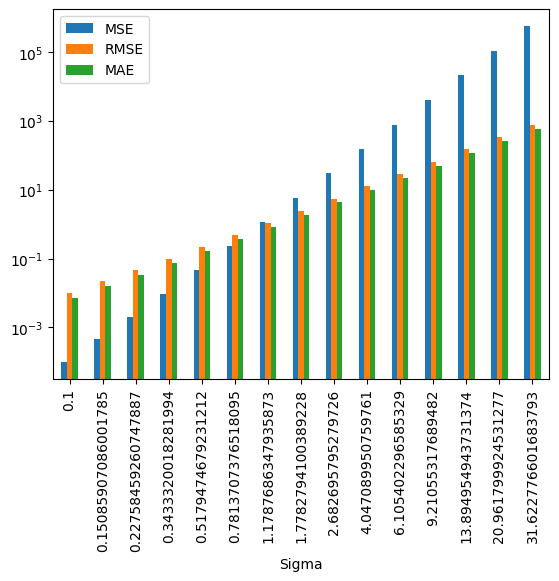


Tabla de métricas para MLP con PSD promedio
╒═══════════╤═════════════════╤══════════════╤══════════════╕
│     Sigma │             MSE │         RMSE │          MAE │
╞═══════════╪═════════════════╪══════════════╪══════════════╡
│  0.1      │     7.57956e-05 │   0.00870607 │   0.00318018 │
├───────────┼─────────────────┼──────────────┼──────────────┤
│  0.150859 │     0.000204372 │   0.0142959  │   0.0056439  │
├───────────┼─────────────────┼──────────────┼──────────────┤
│  0.227585 │     0.000375368 │   0.0193744  │   0.00954907 │
├───────────┼─────────────────┼──────────────┼──────────────┤
│  0.343332 │     0.0010334   │   0.0321466  │   0.0210658  │
├───────────┼─────────────────┼──────────────┼──────────────┤
│  0.517947 │     0.00276936  │   0.0526247  │   0.0378073  │
├───────────┼─────────────────┼──────────────┼──────────────┤
│  0.781371 │     0.0110848   │   0.105284   │   0.0816629  │
├───────────┼─────────────────┼──────────────┼──────────────┤
│  1.17877  │     0.04601

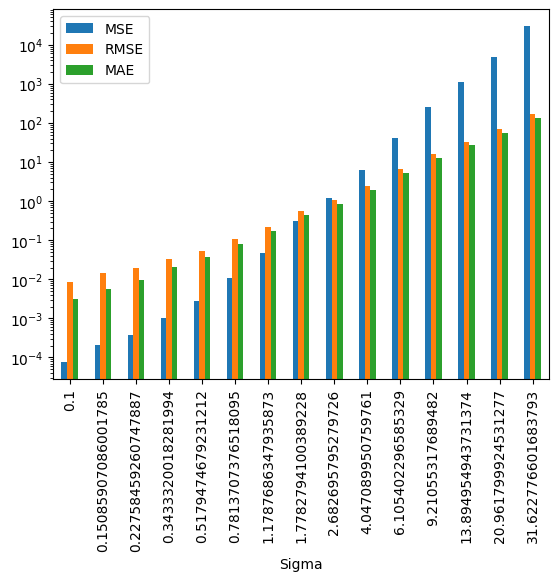


Tabla de métricas para LSTM
╒═══════════╤══════════════════╤══════════════╤═══════════════╕
│     Sigma │              MSE │         RMSE │           MAE │
╞═══════════╪══════════════════╪══════════════╪═══════════════╡
│  0.1      │      0.000179093 │    0.0133826 │    0.00714908 │
├───────────┼──────────────────┼──────────────┼───────────────┤
│  0.150859 │      0.000620135 │    0.0249025 │    0.0156498  │
├───────────┼──────────────────┼──────────────┼───────────────┤
│  0.227585 │      0.00225583  │    0.0474956 │    0.033244   │
├───────────┼──────────────────┼──────────────┼───────────────┤
│  0.343332 │      0.00972302  │    0.0986054 │    0.0745212  │
├───────────┼──────────────────┼──────────────┼───────────────┤
│  0.517947 │      0.0474535   │    0.217838  │    0.167657   │
├───────────┼──────────────────┼──────────────┼───────────────┤
│  0.781371 │      0.229583    │    0.479149  │    0.373789   │
├───────────┼──────────────────┼──────────────┼───────────────┤
│  1.17877 

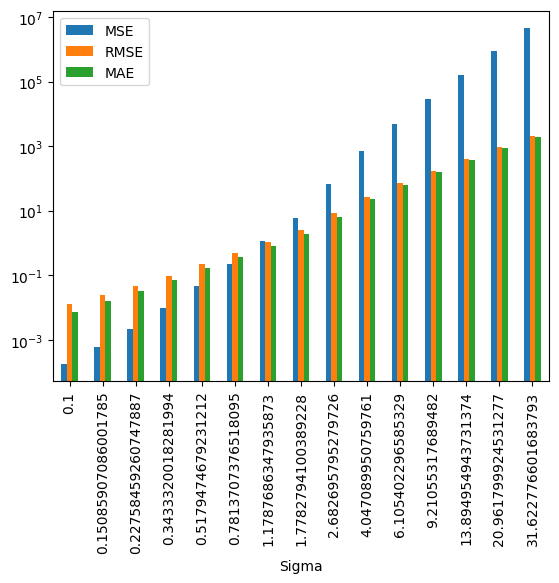

In [7]:
import matplotlib.pyplot as plt

# Convertir resultados a DataFrame
df_results = pd.DataFrame(results)

# Crear DataFrames para cada modelo
df_mlp = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['MLP MSE'],
    'RMSE': df_results['MLP RMSE'],
    'MAE': df_results['MLP MAE']
})

df_mlp_avg = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['MLP with Avg PSD MSE'],
    'RMSE': df_results['MLP with Avg PSD RMSE'],
    'MAE': df_results['MLP with Avg PSD MAE']
})

df_lstm = pd.DataFrame({
    'Sigma': df_results['Sigma'],
    'MSE': df_results['LSTM MSE'],
    'RMSE': df_results['LSTM RMSE'],
    'MAE': df_results['LSTM MAE']
})

# Mostrar tablas con formato personalizado
def mostrar_tabla(df, titulo):
    print(f"\n{titulo}")
    print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))
    df.plot(x='Sigma', logy=True, kind='bar')
    plt.show()

mostrar_tabla(df_mlp, "Tabla de métricas para MLP")
mostrar_tabla(df_mlp_avg, "Tabla de métricas para MLP con PSD promedio")
mostrar_tabla(df_lstm, "Tabla de métricas para LSTM")